<a href="https://colab.research.google.com/github/Hramchenko/Handwritting/blob/master/IIII_min_unif_Fin_V11_of_EQ_no_prof_simpl_new_proffs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
print("Device " + torch.cuda.get_device_name(0))
device = torch.device("cuda:0")
#device = torch.device("cpu")
print(device)

Device Tesla K80
cuda:0


In [0]:
batch_size = 100

image_width = 1000
image_height = 200

In [0]:
import os
import cv2
from xml.dom import minidom
import matplotlib.pyplot as plt
from math import floor
from random import random
import scipy as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
        

In [5]:
import sys
sys.path.append("./Handwritting/")
from IAMWords import IAMWords


pad_length=-1
train_set = IAMWords("train", "./IAM/", batch_size=batch_size, line_height=image_height, line_width=image_width, scale=1, pad_length=pad_length, rand_x=20)
test_set = IAMWords("test", "./IAM/", batch_size=batch_size, line_height=image_height, line_width=image_width, scale=1, pad_length=pad_length, rand_x=20)

Reading ./IAM/words.train.pkl...
Reading finished
Reading ./IAM/words.test.pkl...
Reading finished


In [6]:
from ArtificialHandwritting import ArtificialHandwritting
artificial_data = ArtificialHandwritting(batch_size, "./MyLetters/", 1.0, image_width, image_height, train_set.encode_word)
data, target = artificial_data.make_random_batch(3, 400)

./MyLetters/a01-107u.xml
./MyLetters/a01-107u.png
./MyLetters/a01-053u.xml
./MyLetters/a01-053u.png
./MyLetters/a01-107.xml
./MyLetters/a01-107.png
./MyLetters/a01-026u.xml
./MyLetters/a01-026u.png
./MyLetters/a01-128.xml
./MyLetters/a01-128.png
./MyLetters/my.xml
./MyLetters/my.jpg


In [7]:
artificial_data.data["my.jpg"].keys()

dict_keys(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 'u', 't', 'v', 'w', 'x', 'y', 'z', 'j'])

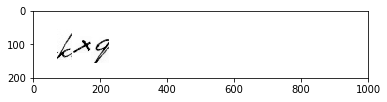

torch.Size([100, 200, 1000])

In [8]:
plt.imshow(data[0], cmap="gray")
plt.show()
data.shape

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.core.debugger import set_trace
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
#!cat ./Handwritting/HTRDecoder.py


In [0]:
from Layers import *
#from HTREncoder import *
#from HTRDecoder import *
from HTRDiscriminator import *

In [0]:
batch = train_set.make_batch(use_binarization=False)
data, target = batch
target = target.to(device)
data = data/255.0
data = data.unsqueeze(1).to(device)

In [0]:
class HTREncoder(nn.Module):
    def __init__(self, batchnorm=True, dropout=False):
        super(HTREncoder, self).__init__()
        
        self.convolutions = nn.Sequential(
        ConvLayer([1, 4, 3], padding=0, stride=2, bn=batchnorm, pool_layer=None),
        ConvLayer([4, 16, 3], padding=0, stride=2, bn=batchnorm, pool_layer=None),
        ConvLayer([16, 32, 3], padding=0, stride=2, bn=batchnorm, pool_layer=None),
        ConvLayer([32, 64, 3], padding=0, stride=1, bn=batchnorm, pool_layer=None))
#        ConvLayer([64, 64, (3, 1)], padding=0, stride=(3, 1), bn=batchnorm, pool_layer=None),
#        ConvLayer([64, 64, (3, 1)], padding=0, stride=(3, 1), bn=batchnorm, pool_layer=None))
        #self.fc = FullyConnectedX([64*15*49, 64*49*3, 64*49], activation_fn=nn.ReLU())
    
    def forward(self, x):
        h = self.convolutions(x)
        h = F.max_pool2d(h, [h.size(0), 1], padding=[0, 0])
        h = h.squeeze(2)
        #h = h.flatten(start_dim=1)
        #h = self.fc(h)
        #h = F.max_pool2d(h, [1, h.size(1)], padding=[0, 0])
        #h = h.permute([2, 3, 0, 1])[0]
        #h = h.permute([2, 3, 0, 1])
        return h

In [0]:
encoder = HTREncoder().to(device)

In [0]:
def restore_cnn(file_name):
  state = torch.load(file_name)
  encoder.load_state_dict(state["encoder"])
restore_cnn("/gdrive/My Drive/cnn.tar")

In [31]:
c = encoder(data)
c.shape

torch.Size([100, 64, 122])

In [0]:
class HTRDecoderResult:
  
  def __init__(self):
    None

class HTRDecoder(nn.Module):
    def __init__(self, batch_size, ntoken, encoded_width=122, encoded_height=64, batchnorm=False, dropout=True, rnn_type="LSTM"):
        super(HTRDecoder, self).__init__()
        self.batch_size = batch_size
        self.ntoken = ntoken
        self.encoded_width = encoded_width
        self.encoded_height = encoded_height
        self.lstm_size = 256
        self.lstm_layers = 2
        self.rnn_type = rnn_type
        self.emb_size = 128
        from math import floor
        self.enc_size = floor(self.encoded_height*encoded_width*0.05)
        self.enc_compress = nn.Linear(self.encoded_height*encoded_width, self.enc_size)
        features_size = self.enc_size + self.emb_size
        
        lstm_inp_size = features_size
        
        if rnn_type == "LSTM":
            self.rnn = nn.LSTM(lstm_inp_size, self.lstm_size, self.lstm_layers, dropout=0.3, bidirectional=False)
        else:
            self.rnn = nn.GRU(lstm_inp_size, self.lstm_size, self.lstm_layers, dropout=0.3, bidirectional=False)
        self.embedding = nn.Embedding(ntoken, self.emb_size)
        self.inpBN = nn.BatchNorm1d(lstm_inp_size)
        self.decoder = nn.Linear(1*self.lstm_size*1, ntoken)#*batch_size)
        self.drop = nn.Dropout(0.3)
        self.attention_inp_size = self.lstm_size*2 + self.encoded_height*encoded_width
        self.attention1 = FullyConnectedX([self.attention_inp_size, floor(self.attention_inp_size*0.7)], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.LeakyReLU(0.2))
        self.attention2 = FullyConnectedX([floor(self.attention_inp_size*0.7), floor(self.attention_inp_size*0.3),  self.encoded_width*self.encoded_height], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh())
        self.attBN1 = nn.BatchNorm1d(self.attention_inp_size)
        self.attBN2 = nn.BatchNorm1d(floor(self.attention_inp_size*0.7))
        self.attention_weights = None
    
    def forward(self, x, prev, hidden=None):
        #x = self.drop(x).squeeze()
        x = x.squeeze()
        #print("xxxxxxxxxxxx")
        #print(x.shape)
        if hidden is not None:
            hidden_m = hidden.permute(1, 0, 2)
            hidden_m = hidden_m.flatten(start_dim=1)
            #print(x.shape)
            #print(hidden_m.shape)
            x_m = x.flatten(start_dim=1)
            attention_inp = torch.cat([x_m, hidden_m], dim=1).detach()
            #print(attention_inp.shape)
            #print(x.shape)
            
            
            attention_inp = self.attBN1(attention_inp)
            
            
            self.attention_weights = self.attention1(attention_inp)
            
            
            self.attention_weights = self.attBN2(self.attention_weights)
            
            
            self.attention_weights = self.attention2(self.attention_weights)
            self.attention_weights = F.softmax(self.attention_weights, dim=1).unsqueeze(1)
            #print("iiiif")
            #print(self.attention_weights.shape)
            
            #self.attention_weights = self.attention_weights.repeat([1, self.encoded_height, 1])
            self.attention_weights = self.attention_weights.view(-1, self.encoded_height, self.encoded_width)
            
            #print("fffff")
            #print(x.shape)
            #print(self.attention_weights.shape)
            x = x * self.attention_weights
        x = self.enc_compress(x.flatten(start_dim=1))
        emb = self.embedding(prev).squeeze().detach()
        x = torch.cat([x, emb], dim=1)
        #x = torch.cat([x.flatten(start_dim=1), emb], dim=1)
        #print(x.shape)
        
        
        x = self.inpBN(x)
        
        
        x = x.unsqueeze(0)
        result = HTRDecoderResult()
        result.rnn_input = x
        result.input_hidden = hidden
        x, hidden = self.rnn(x, hidden)
        x = x.squeeze(dim=0)
        #x = self.drop(x)
        x = self.decoder(x)
        x = F.log_softmax(x, dim=1)
        result.x = x
        result.hidden = hidden
        return result
      
    def makeHidden(self):
        if self.rnn_type == "LSTM":
            h1 = torch.zeros(self.lstm_layers, self.batch_size, self.lstm_size)
            h2 = torch.zeros(self.lstm_layers, self.batch_size, self.lstm_size)
            return (h1, h2)
        else:
            h1 = torch.zeros(self.lstm_layers, self.batch_size, self.lstm_size)
            return h1


decoder = HTRDecoder(batch_size, len(train_set.codes), rnn_type="GRU").to(device)

In [0]:
START = train_set.codes['<START>']
current_symbol = torch.LongTensor(batch_size, 1).to(device)
current_symbol[:, :] = START

In [0]:
def test(max_size, prob, randx):
  print("Testing...")
  
  freq = 20
  
  test_set.to_start(max_size, equalize_freq=True)
  batch_idx = 0
  c_loss = 0
  START = train_set.start_code
  STOP = train_set.stop_code
  recognition_result = torch.LongTensor(batch_size, 30+1).to(device)
  recognition_result.fill_(START)
  old_symbol = torch.LongTensor(batch_size, 1).to(device)
  
  stop_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol.fill_(STOP)
  
  test_loss = 0
  
  with torch.no_grad():  
    while True:

      if random() <= prob:
        if (prob >= 1) and (batch_idx > 100):
          break
        l = 1 + floor(max_size*random())
        data, target = artificial_data.make_random_batch(l, randx)
        orig_data = data;
        data = data.unsqueeze(1).to(device)
        target = target.to(device)  
      else:  
        batch = test_set.make_batch()
        if batch is None:
          break
        orig_data, target = batch
        data = orig_data/255.0
        #data = data.view(batch_size, 1, image_width, image_height).to(device)
        data = data.unsqueeze(1).to(device)
        target = target.to(device)
      hidden = decoder.makeHidden().to(device)    
      loss = 0
      enc = encoder(data)
      s = enc
      s = s.detach()

      old_symbol[:, 0] = START
      for i in range(0, target.shape[1] + 1):
        decoder_result = decoder(s, old_symbol, hidden)
        dec = decoder_result.x
        hidden = decoder_result.hidden

        recognition_result[:, i] = dec.topk(1, dim=1)[1].flatten().detach()
        old_symbol[:, 0] = recognition_result[:, i]#target[:, i]
        k = 1
        if i == target.shape[1]:
          target_symbol = stop_symbol[:, 0]
          k = 1.5
        else:
          target_symbol = target[:, i]  
        loss += k*criterion(dec, target_symbol)
      c_loss += loss.item()/(target.shape[1] + 1)
      test_loss += loss.item()/(target.shape[1] + 1)
      if (batch_idx % freq == 0) and (batch_idx != 0):
        if True:#not use_teacher_forcing:
          print(target.shape[0])
          for k in range(0, min(3, target.shape[0])):
              decoded = recognition_result[k,0:target.shape[1] + 1]
              plt.imshow(orig_data[k].cpu(), cmap="gray")
              plt.show()
              print("  '" + train_set.decode_word(target[k,:]) + "' -> '" + train_set.decode_word(decoded) + "'")
        c_loss /= freq 
        print("  Batch: " + str(batch_idx) + " Loss: " + str(c_loss))
        c_loss = 0
      batch_idx += 1  
  print("Test loss: %f" % (test_loss/batch_idx))   

torch.Size([122])


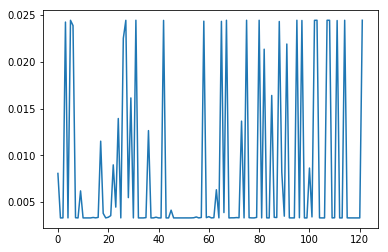

torch.Size([122])


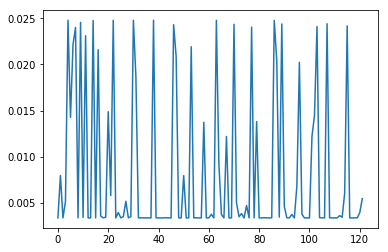

torch.Size([122])


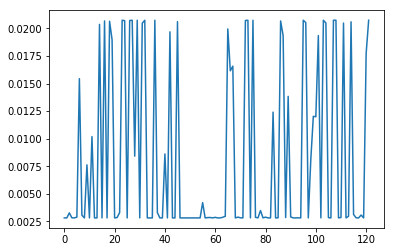

torch.Size([122])


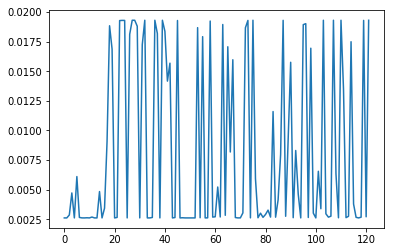

In [0]:
recognition_result = torch.LongTensor(batch_size, 30+1).to(device)
recognition_result.fill_(START)
old_symbol = torch.LongTensor(batch_size, 1).to(device)
test_set.to_start(8, equalize_freq=True)
batch = test_set.make_batch()
orig_data, target = batch
data = orig_data/255.0
data = data.unsqueeze(1).to(device)
target = target.to(device)
#data, target = artificial_data.make_random_batch(8, 20)
#data = data.unsqueeze(1).to(device)
#target = target.to(device)  


hidden = decoder.makeHidden().to(device)  
enc = encoder(data)
s = enc
s = s.detach()

old_symbol[:, 0] = START
for i in range(0, target.shape[1] + 1):
  decoder_result = decoder(s, old_symbol, hidden)
  dec = decoder_result.x
  hidden = decoder_result.hidden

  recognition_result[:, i] = dec.topk(1, dim=1)[1].flatten().detach()
  old_symbol[:, 0] = recognition_result[:, i]
  w = decoder.attention_weights.cpu().detach()[1]
  w = w[0,:]
  print(w.shape)
  plt.plot(w.numpy())
#  plt.imshow(w, cmap="gray")
  plt.show()





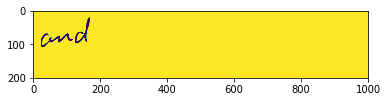

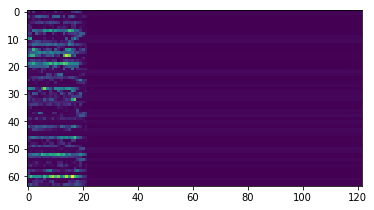

In [0]:
plt.imshow(data[0][0].detach().cpu())
plt.show()
plt.imshow(enc[0].detach().cpu())
plt.show()

In [0]:
data[0][0].shape

torch.Size([200, 1000])

In [0]:
t1 = torch.Tensor([[1, 2, 3]])
t2 = torch.Tensor([[3, 6, 5]])
print(F.softmax(t1, dim=1))
print(F.softmax(t2, dim=1))
tc = torch.cat([t1, t2], dim=0)
print(F.softmax(tc, dim=1))


tensor([[0.0900, 0.2447, 0.6652]])
tensor([[0.0351, 0.7054, 0.2595]])
tensor([[0.0900, 0.2447, 0.6652],
        [0.0351, 0.7054, 0.2595]])


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from Layers import *

# Based on: https://github.com/aryopg/Professor_Forcing_Pytorch/blob/master/models/losses.py
class HTRDiscriminator(nn.Module):
    def __init__(self, batch_size, input_size, hidden_size, input_length, symbs_cnt):
        super(HTRDiscriminator, self).__init__()
        self.batch_size = batch_size
        self.embedding = nn.Embedding(symbs_cnt, 128)
        
        from math import floor
        #self.hidden_cells = 256
        #self.hidden_layers = 2
        
        self.hidden_size = hidden_size
        self.input_length = input_length
        self.rnn_layers = 1#2
        
        input_size = 8576
        gru_input_size = 512
        self.bn1 = nn.BatchNorm1d(input_size)
        self.enc = FullyConnectedX([input_size, floor(input_size*0.7), gru_input_size], activation_fn=nn.ReLU())
        self.bn2 = nn.BatchNorm1d(gru_input_size)
        self.batchnorm = nn.BatchNorm1d(gru_input_size)
        self.gru = nn.GRU(gru_input_size, hidden_size, self.rnn_layers)
        gru_out = hidden_size
        self.fc = FullyConnectedX([gru_out, floor(gru_out*0.7), floor(gru_out*0.3), 1], activation_fn=nn.ReLU())
        self.optimizer = optim.Adam(self.parameters(), lr=1e-4, weight_decay=0.00005)
        
    def zero_grad(self):
        self.optimizer.zero_grad()

    def apply(self, hidden, hidden_states, dec_inputs, dec_outputs, targets):
        emb_outputs = self.embedding(dec_outputs)#.permute(1, 0, 2)
        hidden_states = hidden_states.permute(1, 0, 2).flatten(start_dim=1)
        dec_inputs = dec_inputs.squeeze(0)
#         print(emb_outputs.shape)
#         print(hidden_states.shape)
#         print(dec_inputs.shape)
        full_input = torch.cat([hidden_states, dec_inputs, emb_outputs], dim=1)
        #print(full_input.shape)
        output = self.enc(full_input)
        output = self.bn2(output)
        output = output.unsqueeze(0)
        output, hidden = self.gru(output, hidden)
        output= output.squeeze(0)
        out = self.fc(output)
#         print(out.shape)
#         print(targets.shape)
        loss = F.binary_cross_entropy_with_logits(out, targets)
        return loss, hidden

    def makeHidden(self):
        return torch.zeros(self.rnn_layers, self.batch_size, self.hidden_size)
      
discriminator = HTRDiscriminator(batch_size, 256*2, 512, 10, len(train_set.codes)).to(device)       
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4, weight_decay=0.00005)

In [0]:
def apply_discriminator(s, target, use_teacher_forcing, train_mode, discriminator_target):
  loss = 0
  START = train_set.start_code
  STOP = train_set.stop_code
  recognition_result = torch.LongTensor(batch_size, 30+1).to(device)
  old_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol.fill_(STOP)
  old_symbol[:, 0] = START

  train_mask = torch.ByteTensor(batch_size).to(device)
  train_mask[:] = 1

  hidden = decoder.makeHidden().to(device)    
  discriminator_loss = 0
  discriminator_hidden = discriminator.makeHidden().to(device)

  discr_features = []
  for i in range(0, target.shape[1] + 1):

    decoder_result = decoder(s, old_symbol, hidden)
    dec = decoder_result.x
    hidden = decoder_result.hidden

    decoder_outputs = dec.topk(1, dim=1)[1].flatten()

    
    if train_mode:
      dl, discriminator_hidden = discriminator.apply(discriminator_hidden.detach(), decoder_result.input_hidden.detach(),decoder_result.rnn_input.detach(), decoder_outputs.detach(), discriminator_target)
    else:
      dl, discriminator_hidden = discriminator.apply(discriminator_hidden, decoder_result.input_hidden, decoder_result.rnn_input, decoder_outputs, discriminator_target)
    if i != 0:
      discriminator_loss += dl

    recognition_result[:, i] = decoder_outputs.detach()
    k = 1
    if i == target.shape[1]:
      target_symbol = stop_symbol[:, 0]
      k = 1.5
    else:
      target_symbol = target[:, i]    
    
    if use_teacher_forcing:
      old_symbol[:, 0] = target_symbol
    else:
      old_symbol[:, 0] = recognition_result[:, i]
    loss += criterion(dec, target_symbol)*k
 
  #discriminator_decision = discriminator.makeDecision(discr_features)
  #print("---------")
  #print(discriminator_decision[0:10])
  #print(discriminator_target[0:10])
  #discriminator_loss = F.binary_cross_entropy_with_logits(discriminator_decision, discriminator_target)

  discriminator_loss /= target.shape[1]
  return (recognition_result, loss, discriminator_loss)

In [0]:
def apply_decoder(s, target, use_teacher_forcing):
  loss = 0
  START = train_set.start_code
  STOP = train_set.stop_code
  recognition_result = torch.LongTensor(batch_size, 30+1).to(device)
  recognition_result.fill_(START)
  old_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol.fill_(STOP)
  old_symbol[:, 0] = START

  hidden = decoder.makeHidden().to(device)  
  
  for i in range(0, target.shape[1] + 1):
    decoder_result = decoder(s, old_symbol, hidden)
    dec = decoder_result.x
    hidden = decoder_result.hidden

    recognition_result[:, i] = dec.topk(1, dim=1)[1].flatten().detach()
    
    k = 1
    if i == target.shape[1]:
      target_symbol = stop_symbol[:, 0]
      k = 1.5
    else:
      target_symbol = target[:, i]
    
    if use_teacher_forcing:
      old_symbol[:, 0] = target_symbol
    else:
      old_symbol[:, 0] = recognition_result[:, i]
    #import pdb; pdb.set_trace()

    loss += k*criterion(dec, target_symbol)
  return (recognition_result, loss)


batch_zeros = torch.zeros(batch_size, 1).to(device)
batch_ones = torch.ones(batch_size, 1).to(device)

In [0]:
#encoder_optimizer = optim.Adam(encoder.parameters(), lr=1e-4, weight_decay=0.00005)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=1e-4, weight_decay=0.00005)


In [0]:
encoder_optimizer = optim.Adam(encoder.parameters(), lr=1e-4, weight_decay=0.00005)

In [0]:

criterion = nn.NLLLoss()
#criterion = nn.CrossEntropyLoss()
from random import random

def train(epoch, max_size, apply_professor, prob, randx):
  print("Training epoch " + str(epoch) + "...")
  freq = 30
  train_set.to_start(max_size, equalize_freq=True)
  batch_idx = 0
  c_loss = 0
  train_loss = 0
  discr_applied = 0
  while True:
    if random() <= prob:
      if (prob >= 1) and (batch_idx > 400):
        break    
      l = 1 + floor(max_size*random())
      data, target = artificial_data.make_random_batch(l, randx)
      data = data.unsqueeze(1).to(device)
      target = target.to(device)
    else:
      batch = train_set.make_batch()
      if batch is None:
        break
      orig_data, target = batch
      data = orig_data/255.0
      data = data.unsqueeze(1).to(device)
      target = target.to(device)
    #encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
#     with torch.no_grad():
#       enc = encoder(data)
#       s = enc
#       s = s.unsqueeze(0)
#       s = s.detach()
    enc = encoder(data)
    s = enc
    s = s.unsqueeze(0)
      
    discr_loss = 1
    if apply_professor:
      discriminator_optimizer.zero_grad()
      det_s = s.detach()
      _, _, tf_loss = apply_discriminator(det_s, target, True, True, batch_ones)
      _, _, fr_loss = apply_discriminator(det_s, target, False, True, batch_zeros)
      dl = tf_loss + fr_loss
      discr_loss = dl.item()
      if (batch_idx % freq == 0) and (batch_idx != 0):
        print("Discr loss: %f" %(dl.item()))
      dl.backward()
      discriminator_optimizer.step()
    D_loss_curr = None
    batch_loss = None  
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    discriminator_optimizer.zero_grad()
    if apply_professor and (discr_loss < 0.2) and (discr_loss > 0.01):
      discriminator_optimizer.zero_grad()
      recognition_result, loss, discriminator_loss = apply_discriminator(s, target, True, False, batch_zeros)
      batch_loss = loss.item()
      loss = loss + discriminator_loss
      D_loss_curr = discriminator_loss.item()
      discr_applied += 1
    else:
      recognition_result, loss = apply_decoder(s, target, True)
      batch_loss = loss.item()
    c_loss += batch_loss/(target.shape[1] + 1)
    train_loss += batch_loss/(target.shape[1] + 1)
    if (batch_idx % freq == 0) and (batch_idx != 0):
      c_loss /= freq 
      print("  Batch: " + str(batch_idx) + " Loss: " + str(c_loss))
      c_loss = 0
    loss.backward()
    
    if False:#D_loss_curr is not None:
      _, _, D_loss_new = apply_discriminator(s, target, True, False, batch_zeros)
      print("old/new: %f / %f Batch %f" %(D_loss_curr, D_loss_new, batch_loss))
    #grad_clip = 0.1
    #torch.nn.utils.clip_grad_norm_(encoder.parameters(), grad_clip)
    #torch.nn.utils.clip_grad_norm_(decoder.parameters(), grad_clip)
    encoder_optimizer.step()
    decoder_optimizer.step()
    batch_idx += 1
  print("Train loss: %f"%(train_loss/batch_idx))
  print("Discr applied %d times."%discr_applied)



In [0]:
file_name = "/gdrive/My Drive/unif v9.tar"

In [0]:
# state = torch.load(file_name)
# encoder.load_state_dict(state["encoder"])
# encoder_optimizer.load_state_dict(state["encoder_optimizer"])
# decoder.load_state_dict(state["decoder"])
# decoder_optimizer.load_state_dict(state["decoder_optimizer"])
# discriminator.load_state_dict(state["discriminator"])
# discriminator_optimizer.load_state_dict(state["discriminator_optimizer"])

In [0]:
 def save_decoder(file_name):
  state_dict = {
        "decoder": decoder.state_dict(),
        "decoder_optimizer": decoder_optimizer.state_dict(),
      }

  torch.save(state_dict, file_name)
  print("Network saved: %s" %file_name)

In [0]:
# for i in range(0, 100):
#   max_size =3
#   prob = 1
#   randx = 750
#   train(i, max_size, False, prob, randx)
#   test(max_size, prob, randx)

In [0]:
decoder_file = "/gdrive/My Drive/decoder3.tar"
#save_decoder(decoder_file)

In [0]:
def restore_decoder(file_name):
  state = torch.load(file_name)
  decoder.load_state_dict(state["decoder"])
  decoder_optimizer.load_state_dict(state["decoder_optimizer"])


In [0]:
#restore_decoder(decoder_file)

In [0]:
#save_net("/gdrive/My Drive/net3s.tar")

In [0]:
decoder8_file = "/gdrive/My Drive/decoder8.tar"

In [0]:
#restore_decoder(decoder8_file)

In [0]:
# for i in range(0, 15):
#   max_size = 8
#   prob = 1
#   randx=20
#   train(i, max_size, False, prob, randx)
#   test(max_size, prob, randx)


In [0]:
#save_decoder(decoder8_file)

In [0]:
 def save_net(file_name):
  state_dict = {
        "encoder": encoder.state_dict(),
        "encoder_optimizer": encoder_optimizer.state_dict(),
        "decoder": decoder.state_dict(),
        "decoder_optimizer": decoder_optimizer.state_dict(),
        "discriminator": discriminator.state_dict(),
        "discriminator_optimizer": discriminator_optimizer.state_dict(),
      }

  torch.save(state_dict, file_name)
  print("Network saved: %s" %file_name)

In [0]:
 def save_decoder_and_discriminator(file_name):
  state_dict = {
        "decoder": decoder.state_dict(),
        "decoder_optimizer": decoder_optimizer.state_dict(),
        "discriminator": discriminator.state_dict(),
        "discriminator_optimizer": discriminator_optimizer.state_dict(),
      }

  torch.save(state_dict, file_name)
  print("Network saved: %s" %file_name)

In [0]:
def restore_net(file_name):
  state = torch.load(file_name)
  encoder.load_state_dict(state["encoder"])
  encoder_optimizer.load_state_dict(state["encoder_optimizer"])
  decoder.load_state_dict(state["decoder"])
  decoder_optimizer.load_state_dict(state["decoder_optimizer"])
  discriminator.load_state_dict(state["discriminator"])
  discriminator_optimizer.load_state_dict(state["discriminator_optimizer"])

In [0]:
def restore_decoder_and_discriminator(file_name):
  state = torch.load(file_name)
  decoder.load_state_dict(state["decoder"])
  decoder_optimizer.load_state_dict(state["decoder_optimizer"])
  discriminator.load_state_dict(state["discriminator"])
  discriminator_optimizer.load_state_dict(state["discriminator_optimizer"])

In [0]:

decoder_discr_8_file = "/gdrive/My Drive/decoder_discr_8.tar"
decoder_discr_8_2_file = "/gdrive/My Drive/decoder_discr_8_2.tar"
decoder_discr_8_cnn_file = "/gdrive/My Drive/decoder_discr_8_cnn.tar"

In [0]:
decoder_discr_8_iam_file = "/gdrive/My Drive/decoder_discr_8_iam.tar"
#save_decoder_and_discriminator(decoder_discr_8_iam_file)

In [0]:
#save_decoder_and_discriminator(decoder_discr_8_2_file)

In [0]:
#save_net(decoder_discr_8_cnn_file)

In [0]:
restore_net(decoder_discr_8_cnn_file)

In [0]:
#restore_decoder_and_discriminator(decoder_discr_8_file)

In [0]:
#restore_decoder_and_discriminator(decoder_discr_8_2_file)

In [0]:
# for i in range(0, 15):
#   max_size = 8
#   prob = 1
#   randx=20
#   train(i, max_size, True, prob, randx)
#   test(max_size, prob, randx)
#   if i % 3 == 0:
#     save_decoder_and_discriminator(decoder_discr_8_file)

Training epoch 0...
  Batch: 30 Loss: 0.7189006722809145
  Batch: 60 Loss: 0.7422231000843186
  Batch: 90 Loss: 0.7730497345170647
  Batch: 120 Loss: 0.7316821769479092
  Batch: 150 Loss: 0.7263882402058631
  Batch: 180 Loss: 0.6876236405542919
  Batch: 210 Loss: 0.6690613343870198
  Batch: 240 Loss: 0.8153457081826434
  Batch: 270 Loss: 0.5298842673878821
  Batch: 300 Loss: 0.6338788561854097
  Batch: 330 Loss: 0.6850449393204753
  Batch: 360 Loss: 0.7463555543101024
  Batch: 390 Loss: 0.8580089156302038
  Batch: 420 Loss: 0.690463680123526
  Batch: 450 Loss: 0.6003900669396869
  Batch: 480 Loss: 0.6165948402716055
  Batch: 510 Loss: 0.6074492209889587
  Batch: 540 Loss: 0.5667136702513097
  Batch: 570 Loss: 0.5992480161581091
  Batch: 600 Loss: 0.7718767787547652
  Batch: 630 Loss: 0.6527768613059055
Train loss: 0.680021
Discr applied 0 times.
Testing...
100


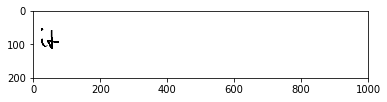

  'it' -> 'it<STOP>'


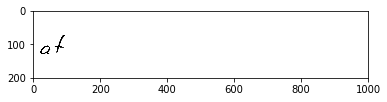

  'at' -> 'at<STOP>'


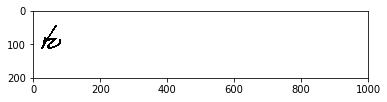

  'to' -> 'to<STOP>'
  Batch: 20 Loss: 1.3438206131921873
100


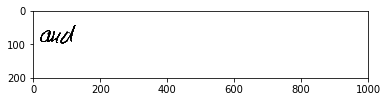

  'and' -> 'and<STOP>'


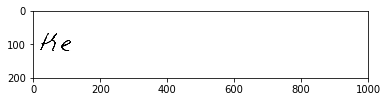

  'the' -> 'its<STOP>'


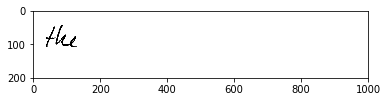

  'the' -> 'the<STOP>'
  Batch: 40 Loss: 1.3804309313164815
100


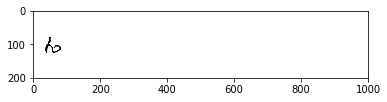

  'to' -> 'to<STOP>'


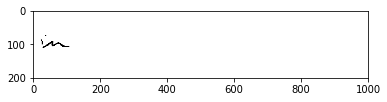

  'in' -> 've<STOP>'


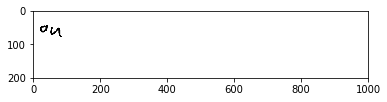

  'on' -> 'on<STOP>'
  Batch: 60 Loss: 0.8905681753903627
Test loss: 1.175961
Training epoch 1...
  Batch: 30 Loss: 0.7148243717163327
  Batch: 60 Loss: 0.7061167195754707
  Batch: 90 Loss: 0.6994297970121816
  Batch: 120 Loss: 0.738449058869765
  Batch: 150 Loss: 0.6820402627528975
  Batch: 180 Loss: 0.5688032075987448
  Batch: 210 Loss: 0.6784193500797585
  Batch: 240 Loss: 0.6139268249695106
  Batch: 270 Loss: 0.8702711558349864
  Batch: 300 Loss: 0.8149197484387293
  Batch: 330 Loss: 0.8066966604224589
  Batch: 360 Loss: 0.768566942091578
  Batch: 390 Loss: 0.6152281562660736
  Batch: 420 Loss: 0.593827892365279
  Batch: 450 Loss: 0.6276312764343761
  Batch: 480 Loss: 0.7197189604751173
  Batch: 510 Loss: 0.6062955719275922
  Batch: 540 Loss: 0.8214606387999954
  Batch: 570 Loss: 0.48638358132706744
  Batch: 600 Loss: 0.612503447772728
  Batch: 630 Loss: 0.7554125675586639
  Batch: 660 Loss: 0.6244947326360712
Train loss: 0.681577
Discr applied 0 times.
Testing...
100


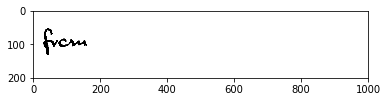

  'from' -> 'from<STOP>'


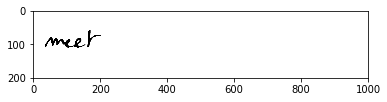

  'meet' -> 'meet<STOP>'


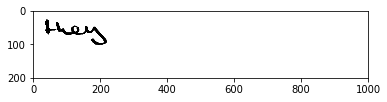

  'they' -> 'thay<STOP>'
  Batch: 20 Loss: 1.2969260418947255
100


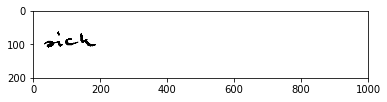

  'sick' -> 'oice<STOP>'


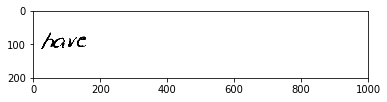

  'have' -> 'have<STOP>'


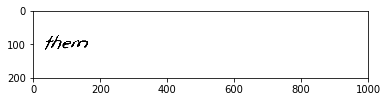

  'them' -> 'than<STOP>'
  Batch: 40 Loss: 1.1567234843401681
100


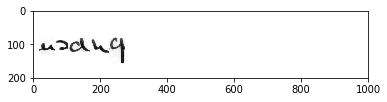

  'nsdhq' -> 'ngady<STOP>'


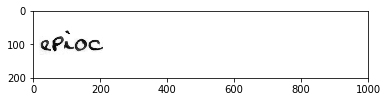

  'epioc' -> 'ejcci<STOP>'


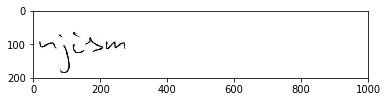

  'njism' -> 'njznv<STOP>'
  Batch: 60 Loss: 0.9122583820174139
Test loss: 1.077608
Training epoch 2...
  Batch: 30 Loss: 0.689128120961801
  Batch: 60 Loss: 0.597997387524635
  Batch: 90 Loss: 0.6267617278833868
  Batch: 120 Loss: 0.8369479631880918
  Batch: 150 Loss: 0.6298668033471971
  Batch: 180 Loss: 0.6010614303227455
  Batch: 210 Loss: 0.6322857275597317
  Batch: 240 Loss: 0.7953798922801776
  Batch: 270 Loss: 0.6241772298629163
  Batch: 300 Loss: 0.5564438776616698
  Batch: 330 Loss: 0.9006922169794482
  Batch: 360 Loss: 0.9234062879504982
  Batch: 390 Loss: 0.5265854413894119
  Batch: 420 Loss: 0.752650857161356
  Batch: 450 Loss: 0.6583432944473767
  Batch: 480 Loss: 0.6752015957504354
  Batch: 510 Loss: 0.5970498571351723
  Batch: 540 Loss: 0.5020459647050926
  Batch: 570 Loss: 0.5693909600566305
  Batch: 600 Loss: 0.6280451788386655
  Batch: 630 Loss: 0.6148284524963016
Train loss: 0.656124
Discr applied 0 times.
Testing...
100


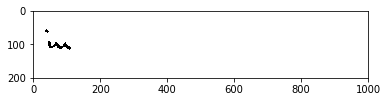

  'in' -> 'in<STOP>'


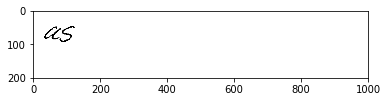

  'as' -> 'as<STOP>'


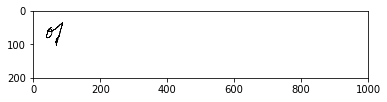

  'of' -> 'of<STOP>'
  Batch: 20 Loss: 0.9505937142634675
100


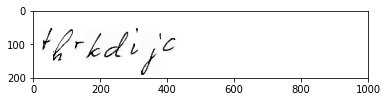

  'thrkdijc' -> 'theatjkx<STOP>'


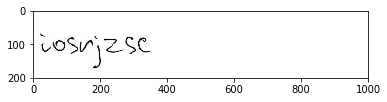

  'iosrjzsc' -> 'iosjzsif<STOP>'


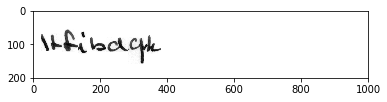

  'ltfibdqk' -> 'lftdadrk<STOP>'
  Batch: 40 Loss: 1.2954315998961055
100


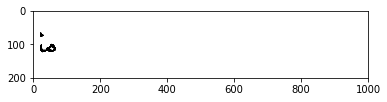

  'is' -> 'is<STOP>'


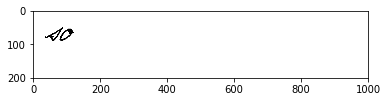

  'so' -> 'as<STOP>'


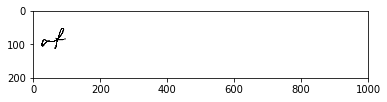

  'of' -> 'of<STOP>'
  Batch: 60 Loss: 0.9264017580697933
Test loss: 1.037806
Training epoch 3...
  Batch: 30 Loss: 0.5835551590610435
  Batch: 60 Loss: 0.666604422651941
  Batch: 90 Loss: 0.6015675901239196
  Batch: 120 Loss: 0.5569091387459683
  Batch: 150 Loss: 0.6657608322609986
  Batch: 180 Loss: 0.571263758074985
  Batch: 210 Loss: 0.671773231674439
  Batch: 240 Loss: 0.4706387806269857
  Batch: 270 Loss: 0.512124321378728
  Batch: 300 Loss: 0.6566907123350119
  Batch: 330 Loss: 0.5412051101695134
  Batch: 360 Loss: 0.652127709057596
  Batch: 390 Loss: 0.4437339501857521
  Batch: 420 Loss: 0.8392309257230433
  Batch: 450 Loss: 0.7806340995864578
  Batch: 480 Loss: 0.6390467424335935
  Batch: 510 Loss: 0.6893567245676325
  Batch: 540 Loss: 0.5950619923804329
  Batch: 570 Loss: 0.6160100673320432
  Batch: 600 Loss: 0.7501135778072334
  Batch: 630 Loss: 0.6473734755238529
  Batch: 660 Loss: 0.5696154937372794
Train loss: 0.621418
Discr applied 0 times.
Testing...
100


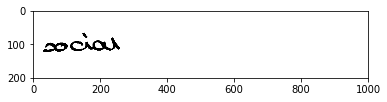

  'social' -> 'socing<STOP>'


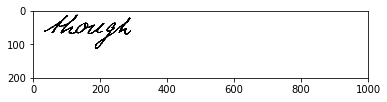

  'though' -> 'himsel<STOP>'


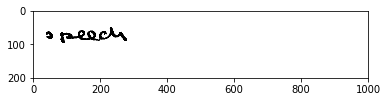

  'speech' -> 'speede<STOP>'
  Batch: 20 Loss: 1.121489301399579
100


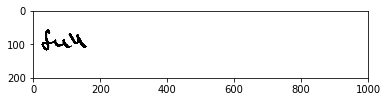

  'full' -> 'fuil<STOP>'


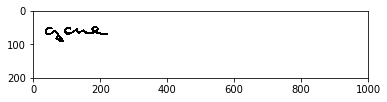

  'gone' -> 'open<STOP>'


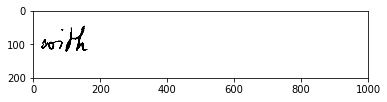

  'with' -> 'anth<STOP>'
  Batch: 40 Loss: 1.3426446167817192
100


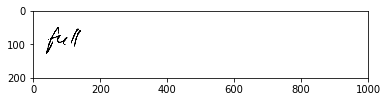

  'full' -> 'flit<STOP>'


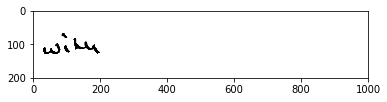

  'with' -> 'with<STOP>'


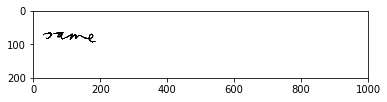

  'same' -> 'rear<STOP>'
  Batch: 60 Loss: 1.0603334627265022
Test loss: 1.105749
Training epoch 4...
  Batch: 30 Loss: 0.547225266151012
  Batch: 60 Loss: 0.6198378151126955
  Batch: 90 Loss: 0.5675344121680846
  Batch: 120 Loss: 0.746953777945231
  Batch: 150 Loss: 0.5839743437253372
  Batch: 180 Loss: 0.5785195218286817
  Batch: 210 Loss: 0.6299558103388105
  Batch: 240 Loss: 0.6844871320074828
  Batch: 270 Loss: 0.7190887939220383
  Batch: 300 Loss: 0.6190465272631911
  Batch: 330 Loss: 0.47918936582311744
  Batch: 360 Loss: 0.47610442864674113
  Batch: 390 Loss: 0.6014723576069193
  Batch: 420 Loss: 0.7119624444369286
  Batch: 450 Loss: 0.543844080200744
  Batch: 480 Loss: 0.49430830550611654
  Batch: 510 Loss: 0.5898142226655332
  Batch: 540 Loss: 0.6314017509168418
  Batch: 570 Loss: 0.6732657373424562
  Batch: 600 Loss: 0.46353824465363114
  Batch: 630 Loss: 0.5706555011285046
Train loss: 0.594371
Discr applied 0 times.
Testing...
100


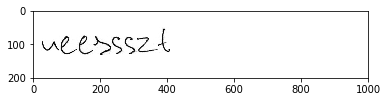

  'ueessszt' -> 'ueesszcg<STOP>'


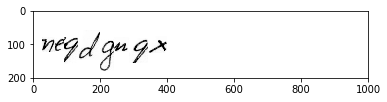

  'neqdgnqx' -> 'ngqhqeqw<STOP>'


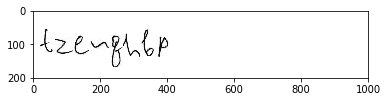

  'tzenqhbp' -> 'tzehhqhr<STOP>'
  Batch: 20 Loss: 1.2397057493716952
100


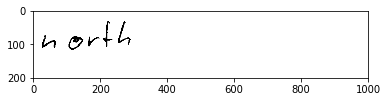

  'north' -> 'morth<STOP>'


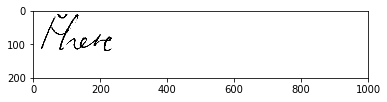

  'there' -> 'there<STOP>'


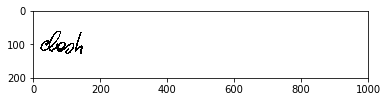

  'clash' -> 'event<STOP>'
  Batch: 40 Loss: 1.157477687034342
100


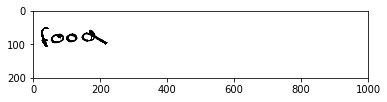

  'food' -> 'food<STOP>'


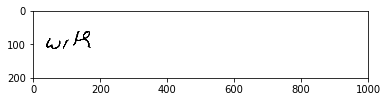

  'with' -> 'with<STOP>'


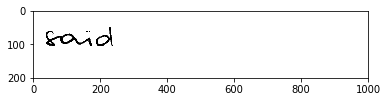

  'said' -> 'soun<STOP>'
  Batch: 60 Loss: 1.0437765143385955
Test loss: 1.099907
Training epoch 5...
  Batch: 30 Loss: 0.5954659380440517
  Batch: 60 Loss: 0.5464955295180832
  Batch: 90 Loss: 0.6714426981192574
  Batch: 120 Loss: 0.6582513581740633
  Batch: 150 Loss: 0.6890465059095906
  Batch: 180 Loss: 0.7234791609569989
  Batch: 210 Loss: 0.8086379728001103
  Batch: 240 Loss: 0.5183432717597675
  Batch: 270 Loss: 0.6456974464757418
  Batch: 300 Loss: 0.6194384384825431
  Batch: 330 Loss: 0.6355082766151933
  Batch: 360 Loss: 0.6208976930147284
  Batch: 390 Loss: 0.5520719175457599
  Batch: 420 Loss: 0.5588045834466105
  Batch: 450 Loss: 0.543573863915902
  Batch: 480 Loss: 0.5348890269242188
  Batch: 510 Loss: 0.5031278967573529
  Batch: 540 Loss: 0.5277829257552586
  Batch: 570 Loss: 0.4859609937005574
  Batch: 600 Loss: 0.7191851812796224
  Batch: 630 Loss: 0.4629848757938101
  Batch: 660 Loss: 0.47431696973267995
Train loss: 0.590207
Discr applied 0 times.
Testing...
100


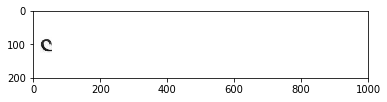

  'c' -> 'c<STOP>'


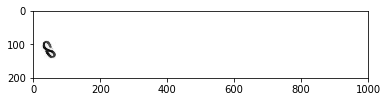

  'g' -> 'g<STOP>'


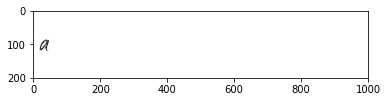

  'a' -> 'a<STOP>'
  Batch: 20 Loss: 1.2207639986087406
100


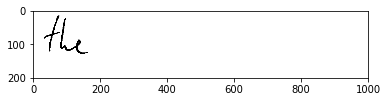

  'the' -> 'the<STOP>'


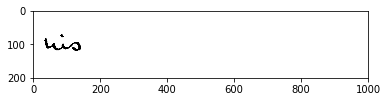

  'his' -> 'his<STOP>'


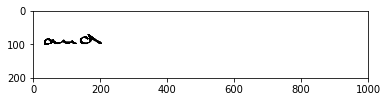

  'and' -> 'and<STOP>'
  Batch: 40 Loss: 1.137435879461349
Test loss: 1.101283
Training epoch 6...
  Batch: 30 Loss: 0.57962447731189
  Batch: 60 Loss: 0.48127301619875984
  Batch: 90 Loss: 0.5794930101402855
  Batch: 120 Loss: 0.4313776968163315
  Batch: 150 Loss: 0.4750567436975146
  Batch: 180 Loss: 0.5118943282476967
  Batch: 210 Loss: 0.6695941516954117
  Batch: 240 Loss: 0.5956692841213453
  Batch: 270 Loss: 0.5944920361286432
  Batch: 300 Loss: 0.5960588110928181
  Batch: 330 Loss: 0.5841577149198326
  Batch: 360 Loss: 0.6371186872512575
  Batch: 390 Loss: 0.43622299510650536
  Batch: 420 Loss: 0.5891239319651056
  Batch: 450 Loss: 0.5266423155373288
  Batch: 480 Loss: 0.5349099452076135
  Batch: 510 Loss: 0.647803620743373
  Batch: 540 Loss: 1.0360367352866307
  Batch: 570 Loss: 0.7571587333366986
  Batch: 600 Loss: 0.652792797623961
  Batch: 630 Loss: 0.4721483092926561
  Batch: 660 Loss: 0.5594844594357348
Train loss: 0.585497
Discr applied 0 times.
Testing...
100


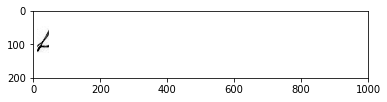

  't' -> 't<STOP>'


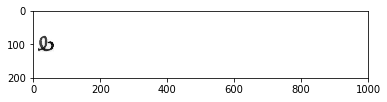

  'b' -> 'b<STOP>'


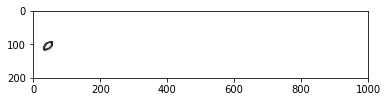

  'o' -> 'o<STOP>'
  Batch: 20 Loss: 1.3124708508877527
100


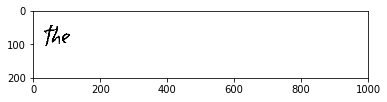

  'the' -> 'the<STOP>'


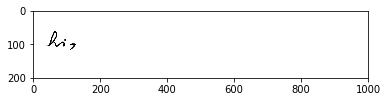

  'his' -> 'bin<STOP>'


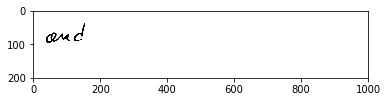

  'and' -> 'and<STOP>'
  Batch: 40 Loss: 0.846203578714104
100


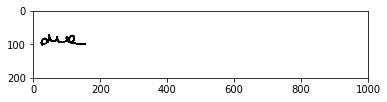

  'due' -> 'dae<STOP>'


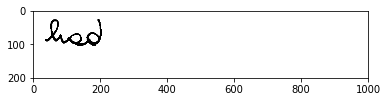

  'had' -> 'had<STOP>'


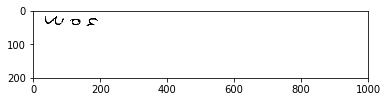

  'was' -> 'was<STOP>'
  Batch: 60 Loss: 1.0783655951893518
Test loss: 1.033950
Training epoch 7...
  Batch: 30 Loss: 0.5024824337519351
  Batch: 60 Loss: 0.5797740535051735
  Batch: 90 Loss: 0.3741128687284611
  Batch: 120 Loss: 0.6291026962304083
  Batch: 150 Loss: 0.7132314215229932
  Batch: 180 Loss: 0.4677836010155697
  Batch: 210 Loss: 0.675282320739731
  Batch: 240 Loss: 0.5434562611311832
  Batch: 270 Loss: 0.5571997093062394
  Batch: 300 Loss: 0.6244716024225351
  Batch: 330 Loss: 0.5268557263224843
  Batch: 360 Loss: 0.48693877884241016
  Batch: 390 Loss: 0.4277529940411212
  Batch: 420 Loss: 0.7126166066322377
  Batch: 450 Loss: 0.6083893366520682
  Batch: 480 Loss: 0.594578832849939
  Batch: 510 Loss: 0.5890222676074693
  Batch: 540 Loss: 0.600802076747099
  Batch: 570 Loss: 0.5052352633088748
  Batch: 600 Loss: 0.5380900273251312
  Batch: 630 Loss: 0.44005262995641387
  Batch: 660 Loss: 0.4293528317620672
Train loss: 0.551996
Discr applied 0 times.
Testing...
100


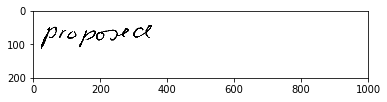

  'proposed' -> 'proposed<STOP>'


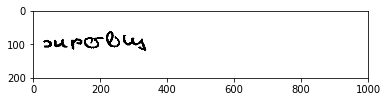

  'superbly' -> 'vuregels<STOP>'


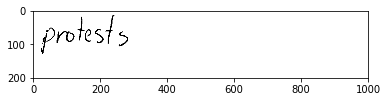

  'protests' -> 'prositin<STOP>'
  Batch: 20 Loss: 1.1294905598709981
100


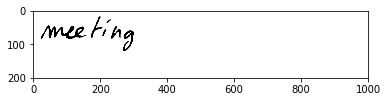

  'meeting' -> 'mectirn<STOP>'


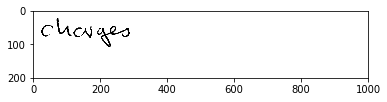

  'charges' -> 'chooped<STOP>'


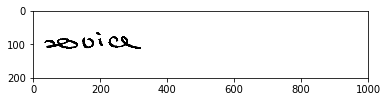

  'service' -> 'seivice<STOP>'
  Batch: 40 Loss: 1.1108910795715121
100


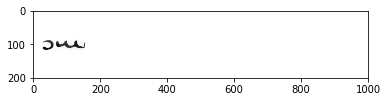

  'sm' -> 'sm<STOP>'


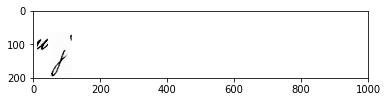

  'uj' -> 'vj<STOP>'


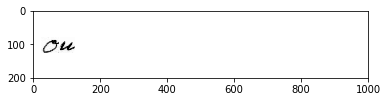

  'ou' -> 'ou<STOP>'
  Batch: 60 Loss: 0.8965115591351476
Test loss: 1.005092
Training epoch 8...
  Batch: 30 Loss: 0.747989693192972
  Batch: 60 Loss: 0.4489854602488102
  Batch: 90 Loss: 0.593694239962629
  Batch: 120 Loss: 0.5489805063877314
  Batch: 150 Loss: 0.5876428171341854
  Batch: 180 Loss: 0.3759381208925572
  Batch: 210 Loss: 0.6166880209420724
  Batch: 240 Loss: 0.48686898173222315
  Batch: 270 Loss: 0.4994092684826523
  Batch: 300 Loss: 0.5636944397440349
  Batch: 330 Loss: 0.4486644202596927
  Batch: 360 Loss: 0.4969910038637105
  Batch: 390 Loss: 0.40976302652368474
  Batch: 420 Loss: 0.4912713881313958
  Batch: 450 Loss: 0.45390433804146835
  Batch: 480 Loss: 0.4383815713147953
  Batch: 510 Loss: 0.5154404833865543
  Batch: 540 Loss: 0.6101402864640668
  Batch: 570 Loss: 0.6352609013328477
  Batch: 600 Loss: 0.4756384311450852
  Batch: 630 Loss: 0.5065746135623367
  Batch: 660 Loss: 0.5104740483033908
  Batch: 690 Loss: 0.306446797831191
Train loss: 0.509837
Discr appl

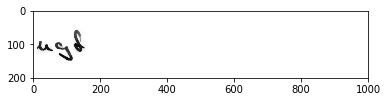

  'kgf' -> 'kgf<STOP>'


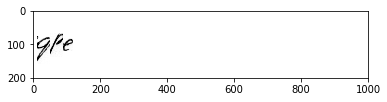

  'qpe' -> 'bpe<STOP>'


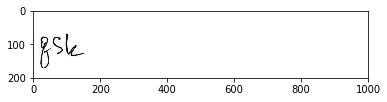

  'qsk' -> 'qsk<STOP>'
  Batch: 20 Loss: 1.0814819423073814
100


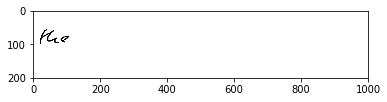

  'the' -> 'her<STOP>'


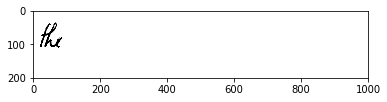

  'the' -> 'the<STOP>'


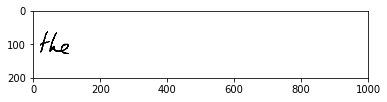

  'the' -> 'the<STOP>'
  Batch: 40 Loss: 1.1553180077861225
100


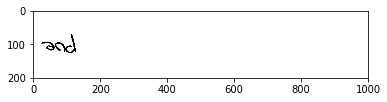

  'and' -> 'sat<STOP>'


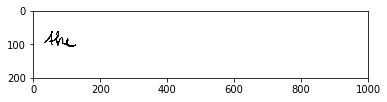

  'the' -> 'the<STOP>'


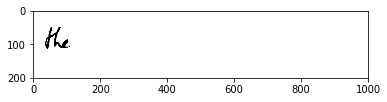

  'the' -> 'the<STOP>'
  Batch: 60 Loss: 1.1123763299839837
Test loss: 1.090160
Training epoch 9...
  Batch: 30 Loss: 0.603688984622085
  Batch: 60 Loss: 0.3570158185354538
  Batch: 90 Loss: 0.40352302247333155
  Batch: 120 Loss: 0.5125830159403344
  Batch: 150 Loss: 0.5382933815635702
  Batch: 180 Loss: 0.5600245690759684
  Batch: 210 Loss: 0.5889892910519445
  Batch: 240 Loss: 0.5432980949301568
  Batch: 270 Loss: 0.5068440409631483
  Batch: 300 Loss: 0.5497285452729496
  Batch: 330 Loss: 0.5461139122995907
  Batch: 360 Loss: 0.583546803167494
  Batch: 390 Loss: 0.48744791730686465
  Batch: 420 Loss: 0.4857664397861513
  Batch: 450 Loss: 0.45919269747913827
  Batch: 480 Loss: 0.5202564126621715
  Batch: 510 Loss: 0.45802367109499836
  Batch: 540 Loss: 0.6338724559088234
  Batch: 570 Loss: 0.6062791109759184
  Batch: 600 Loss: 0.5081069344774913
  Batch: 630 Loss: 0.49999774138842307
  Batch: 660 Loss: 0.474510253155259
Train loss: 0.514461
Discr applied 0 times.
Testing...
100


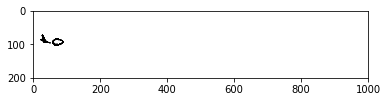

  'to' -> 'to<STOP>'


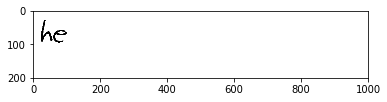

  'he' -> 'he<STOP>'


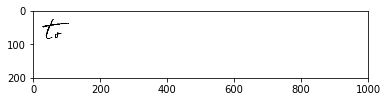

  'to' -> 'to<STOP>'
  Batch: 20 Loss: 1.2856577217803586
100


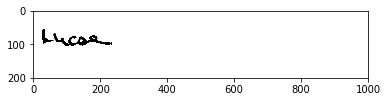

  'those' -> 'turee<STOP>'


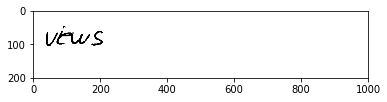

  'views' -> 'veing<STOP>'


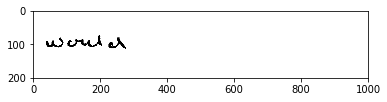

  'would' -> 'would<STOP>'
  Batch: 40 Loss: 0.8427839179573551
100


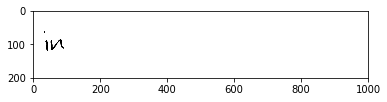

  'in' -> 'in<STOP>'


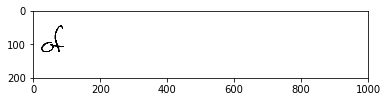

  'of' -> 'of<STOP>'


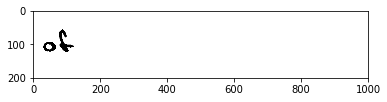

  'of' -> 'of<STOP>'
  Batch: 60 Loss: 0.8063549137683139
Test loss: 0.981509
Training epoch 10...
  Batch: 30 Loss: 0.5908764874710449
  Batch: 60 Loss: 0.5056181894550248
  Batch: 90 Loss: 0.4601739872794933
  Batch: 120 Loss: 0.44924848635932285
  Batch: 150 Loss: 0.3893764136566055
  Batch: 180 Loss: 0.5040159980349598
  Batch: 210 Loss: 0.45888926814078645
  Batch: 240 Loss: 0.6888091342127513
  Batch: 270 Loss: 0.5545817296230605
  Batch: 300 Loss: 0.699003140757639
  Batch: 330 Loss: 0.6609146178509825
  Batch: 360 Loss: 0.6585904760059541
  Batch: 390 Loss: 0.45648212813314
  Batch: 420 Loss: 0.5575837066911515
  Batch: 450 Loss: 0.5861306903952801
  Batch: 480 Loss: 0.5399023629180969
  Batch: 510 Loss: 0.4076203472746743
  Batch: 540 Loss: 0.4616119709003854
  Batch: 570 Loss: 0.4194615380836542
  Batch: 600 Loss: 0.5460935926729094
  Batch: 630 Loss: 0.4206069431045935
  Batch: 660 Loss: 0.38891913799539446
Train loss: 0.515869
Discr applied 0 times.
Testing...
100


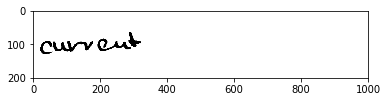

  'current' -> 'cwrents<STOP>'


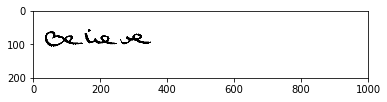

  'believe' -> 'eatiece<STOP>'


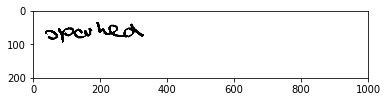

  'sparked' -> 'spwbled<STOP>'
  Batch: 20 Loss: 1.2887763676934298
100


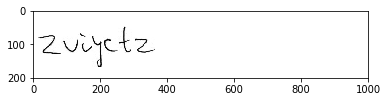

  'zviyctz' -> 'zviyizs<STOP>'


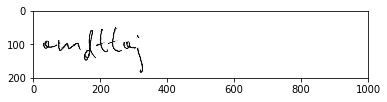

  'amdttaj' -> 'anddjch<STOP>'


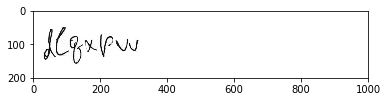

  'dlqxpvv' -> 'dlqryvn<STOP>'
  Batch: 40 Loss: 1.005479729477139
100


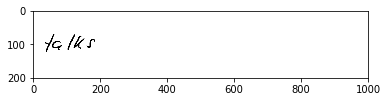

  'talks' -> 'talls<STOP>'


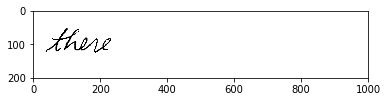

  'there' -> 'there<STOP>'


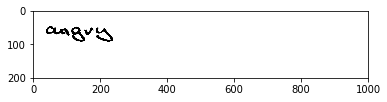

  'angry' -> 'angoy<STOP>'
  Batch: 60 Loss: 1.0119458041597333
Test loss: 1.010425
Training epoch 11...
  Batch: 30 Loss: 0.41494154444210746
  Batch: 60 Loss: 0.45302318865699426
  Batch: 90 Loss: 0.37410263838827923
  Batch: 120 Loss: 0.4002941379463547
  Batch: 150 Loss: 0.44047137487817695
  Batch: 180 Loss: 0.5666357804089784
  Batch: 210 Loss: 0.47472509140493696
  Batch: 240 Loss: 0.6125734437726161
  Batch: 270 Loss: 0.47457514545904894
  Batch: 300 Loss: 0.42085150837287233
  Batch: 330 Loss: 0.46122902515171843
  Batch: 360 Loss: 0.42954253764064215
  Batch: 390 Loss: 0.43017750247958164
  Batch: 420 Loss: 0.41165710113883497
  Batch: 450 Loss: 0.42390401688360035
  Batch: 480 Loss: 0.4114959357787299
  Batch: 510 Loss: 0.5343640559462327
  Batch: 540 Loss: 0.49080140791261795
  Batch: 570 Loss: 0.43525382186685296
  Batch: 600 Loss: 0.4142992437333263
Train loss: 0.453835
Discr applied 0 times.
Testing...
100


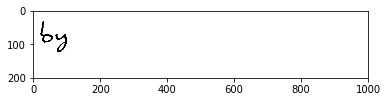

  'by' -> 'by<STOP>'


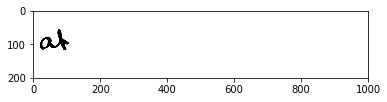

  'at' -> 'at<STOP>'


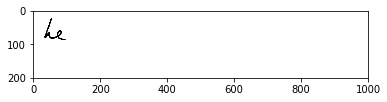

  'he' -> 'he<STOP>'
  Batch: 20 Loss: 0.9815020649507641
100


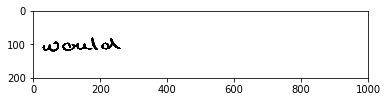

  'would' -> 'would<STOP>'


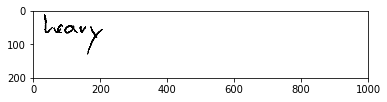

  'heavy' -> 'heary<STOP>'


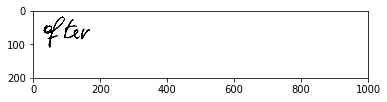

  'after' -> 'geler<STOP>'
  Batch: 40 Loss: 1.1369128508558348
100


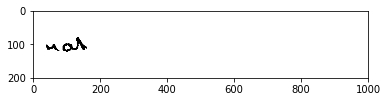

  'not' -> 'now<STOP>'


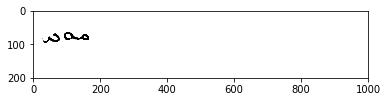

  'was' -> 'was<STOP>'


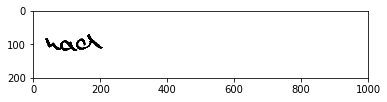

  'had' -> 'had<STOP>'
  Batch: 60 Loss: 0.8825214983398716
Test loss: 0.967251
Training epoch 12...
  Batch: 30 Loss: 0.4309040240040689
  Batch: 60 Loss: 0.546074218770499
  Batch: 90 Loss: 0.5177985410352863
  Batch: 120 Loss: 0.5802792296649286
  Batch: 150 Loss: 0.4568842806288647
  Batch: 180 Loss: 0.42959828670240113
  Batch: 210 Loss: 0.47932445474008406
  Batch: 240 Loss: 0.4096792302249127
  Batch: 270 Loss: 0.5339016917103497
  Batch: 300 Loss: 0.45467332982384256
  Batch: 330 Loss: 0.5159182310175329
  Batch: 360 Loss: 0.4468994351602578
  Batch: 390 Loss: 0.39807944380259397
  Batch: 420 Loss: 0.3701578625914438
  Batch: 450 Loss: 0.4565245570648441
  Batch: 480 Loss: 0.4896189740205567
  Batch: 510 Loss: 0.43862793948264805
  Batch: 540 Loss: 0.5433778440272288
  Batch: 570 Loss: 0.7576904643356563
  Batch: 600 Loss: 0.5590569748895036
  Batch: 630 Loss: 0.4647339122517714
Train loss: 0.482330
Discr applied 0 times.
Testing...
100


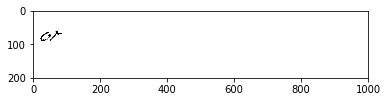

  'or' -> 'as<STOP>'


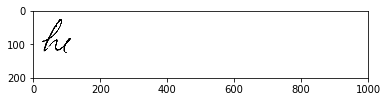

  'he' -> 'he<STOP>'


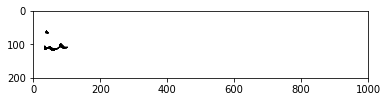

  'in' -> 'no<STOP>'
  Batch: 20 Loss: 0.8972432063809697
100


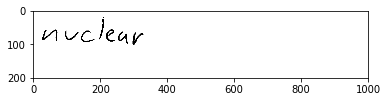

  'nuclear' -> 'verkeal<STOP>'


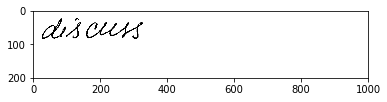

  'discuss' -> 'distings'


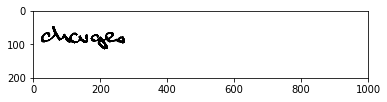

  'charges' -> 'shinger<STOP>'
  Batch: 40 Loss: 1.1681395812172974
100


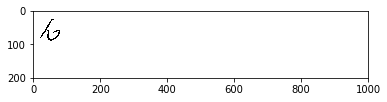

  'to' -> 'to<STOP>'


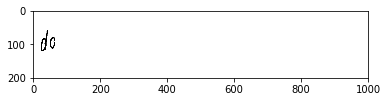

  'do' -> 'bo<STOP>'


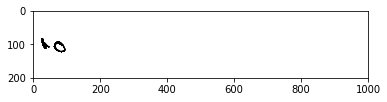

  'to' -> 'be<STOP>'
  Batch: 60 Loss: 0.83699208739258
Test loss: 0.985654
Training epoch 13...
  Batch: 30 Loss: 0.6459787304644231
  Batch: 60 Loss: 0.6322198432203007
  Batch: 90 Loss: 0.48802247581422026
  Batch: 120 Loss: 0.5285356947899891
  Batch: 150 Loss: 0.45638712058464687
  Batch: 180 Loss: 0.39325937759584534
  Batch: 210 Loss: 0.4274153834510417
  Batch: 240 Loss: 0.36569373093900226
  Batch: 270 Loss: 0.5630236114608863
  Batch: 300 Loss: 0.4898218034417738
  Batch: 330 Loss: 0.4338751215909524
  Batch: 360 Loss: 0.3672437776601505
  Batch: 390 Loss: 0.4463438970774964
  Batch: 420 Loss: 0.3091830447499478
  Batch: 450 Loss: 0.39570917001516415
  Batch: 480 Loss: 0.3832961056369638
  Batch: 510 Loss: 0.345397021504188
  Batch: 540 Loss: 0.2853287116245973
  Batch: 570 Loss: 0.3902242757017335
  Batch: 600 Loss: 0.49198747218187366
  Batch: 630 Loss: 0.38477544451753304
  Batch: 660 Loss: 0.3175507244349472
Train loss: 0.431846
Discr applied 0 times.
Testing...
100


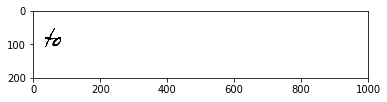

  'to' -> 'to<STOP>'


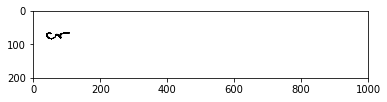

  'or' -> 'ar<STOP>'


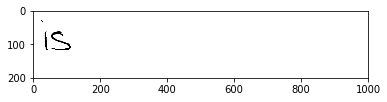

  'is' -> 'is<STOP>'
  Batch: 20 Loss: 1.1512792724110776
100


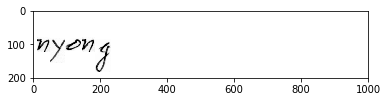

  'nyong' -> 'nyong<STOP>'


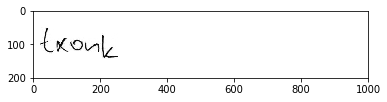

  'txonk' -> 'txoxd<STOP>'


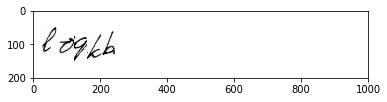

  'loqkb' -> 'ldskk<STOP>'
  Batch: 40 Loss: 1.119482532011138
100


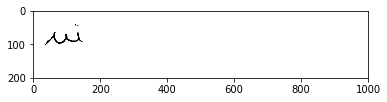

  'in' -> 'in<STOP>'


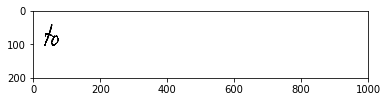

  'to' -> 'to<STOP>'


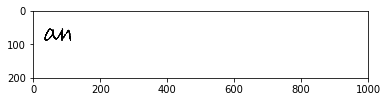

  'an' -> 'an<STOP>'
  Batch: 60 Loss: 0.9269205102040654
Test loss: 1.031669
Training epoch 14...
  Batch: 30 Loss: 0.45956746085788364
  Batch: 60 Loss: 0.39232516334889816
  Batch: 90 Loss: 0.7251652399454483
  Batch: 120 Loss: 0.41207520472230735
  Batch: 150 Loss: 0.5247807044232332
  Batch: 180 Loss: 0.47934104218842494
  Batch: 210 Loss: 0.6315304076923894
  Batch: 240 Loss: 0.34561894566648543
  Batch: 270 Loss: 0.38070272052769
  Batch: 300 Loss: 0.39305075757619395
  Batch: 330 Loss: 0.4477052530179184
  Batch: 360 Loss: 0.3865652785373348
  Batch: 390 Loss: 0.3782490268775395
  Batch: 420 Loss: 0.3805367273979243
  Batch: 450 Loss: 0.44317180248893917
  Batch: 480 Loss: 0.3977834105917386
  Batch: 510 Loss: 0.40397343124800095
  Batch: 540 Loss: 0.35859940965241066
  Batch: 570 Loss: 0.567258395918857
  Batch: 600 Loss: 0.3024421147375353
  Batch: 630 Loss: 0.41845058209366276
Train loss: 0.440171
Discr applied 0 times.
Testing...
100


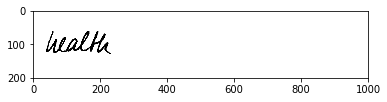

  'health' -> 'health<STOP>'


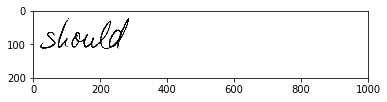

  'should' -> 'sudled<STOP>'


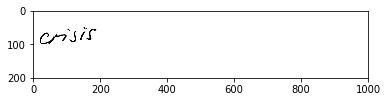

  'crisis' -> 'arisit<STOP>'
  Batch: 20 Loss: 0.9673225482588723
100


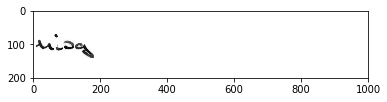

  'hisg' -> 'hiog<STOP>'


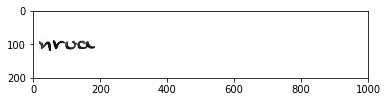

  'nrva' -> 'npva<STOP>'


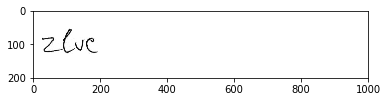

  'zlvc' -> 'zlcv<STOP>'
  Batch: 40 Loss: 0.8761096489429475
100


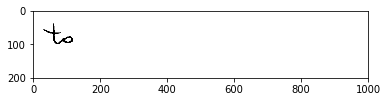

  'to' -> 'to<STOP>'


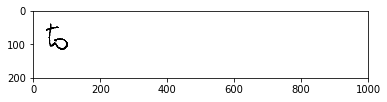

  'to' -> 'to<STOP>'


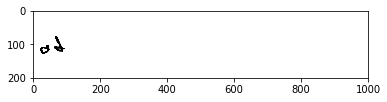

  'of' -> 'of<STOP>'
  Batch: 60 Loss: 1.2398857168924242
Test loss: 0.986031
Training epoch 15...
  Batch: 30 Loss: 0.40145660267108013
  Batch: 60 Loss: 0.5343700313284284
  Batch: 90 Loss: 0.5041865882395752
  Batch: 120 Loss: 0.5362107597622606
  Batch: 150 Loss: 0.5220270845011152
  Batch: 180 Loss: 0.41650628184810995
  Batch: 210 Loss: 0.3629738403821275
  Batch: 240 Loss: 0.3812485115308926
  Batch: 270 Loss: 0.40908325755052144
  Batch: 300 Loss: 0.4940036404249134
  Batch: 330 Loss: 0.46955770970435523
  Batch: 360 Loss: 0.4727470400409093
  Batch: 390 Loss: 0.41116857649561356
  Batch: 420 Loss: 0.36475483852837765
  Batch: 450 Loss: 0.44060563212191617
  Batch: 480 Loss: 0.373850263882251
  Batch: 510 Loss: 0.46451338069483866
  Batch: 540 Loss: 0.34565928723879913
  Batch: 570 Loss: 0.37336807813712203
  Batch: 600 Loss: 0.34924232677847306
  Batch: 630 Loss: 0.43440381110148146
Train loss: 0.429043
Discr applied 0 times.
Testing...
100


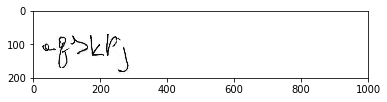

  'aqskpj' -> 'aqstxp<STOP>'


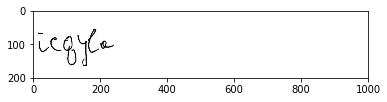

  'icqyla' -> 'icqgue<STOP>'


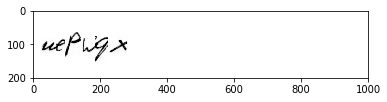

  'uepwqx' -> 'uepqxi<STOP>'
  Batch: 20 Loss: 1.0825591668108152
100


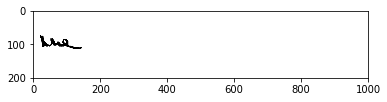

  'the' -> 'ine<STOP>'


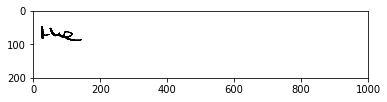

  'the' -> 'the<STOP>'


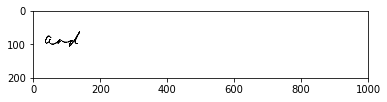

  'and' -> 'and<STOP>'
  Batch: 40 Loss: 0.7911591043074926
100


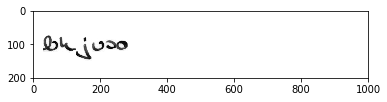

  'bkjvso' -> 'bkiybs<STOP>'


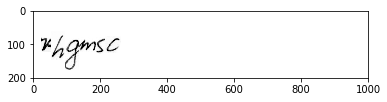

  'vhgmsc' -> 'vhymos<STOP>'


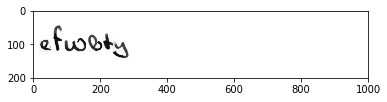

  'efwbty' -> 'etbybt<STOP>'
  Batch: 60 Loss: 1.0859431743036423
Test loss: 0.952397
Training epoch 16...
  Batch: 30 Loss: 0.37744615909934215
  Batch: 60 Loss: 0.4031223093856264
  Batch: 90 Loss: 0.4495983919930994
  Batch: 120 Loss: 0.4036970507440272
  Batch: 150 Loss: 0.3271752283275718
  Batch: 180 Loss: 0.43720205157995223
  Batch: 210 Loss: 0.49695999122663304
  Batch: 240 Loss: 0.4638864579710064
  Batch: 270 Loss: 0.44385998058926185
  Batch: 300 Loss: 0.44782986570524164
  Batch: 330 Loss: 0.39429952351110314
  Batch: 360 Loss: 0.34931111576390406
  Batch: 390 Loss: 0.3864408586199874
  Batch: 420 Loss: 0.41423000261226967
  Batch: 450 Loss: 0.34051188235107077
  Batch: 480 Loss: 0.4551100706259804
  Batch: 510 Loss: 0.4602854346673167
  Batch: 540 Loss: 0.3857105818965409
  Batch: 570 Loss: 0.42590273923777716
  Batch: 600 Loss: 0.4497556081686228
  Batch: 630 Loss: 0.5381094599905469
  Batch: 660 Loss: 0.5332593600022256
Train loss: 0.425887
Discr applied 0 times.
Testin

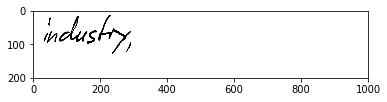

  'industry' -> 'vustrates'


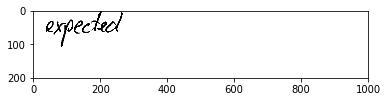

  'expected' -> 'expeated<STOP>'


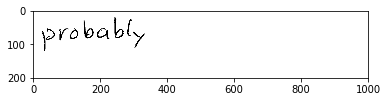

  'probably' -> 'groubling'
  Batch: 20 Loss: 0.9718779441678806
100


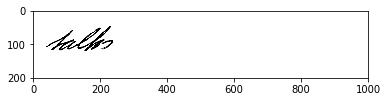

  'talks' -> 'thate<STOP>'


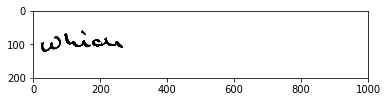

  'which' -> 'wines<STOP>'


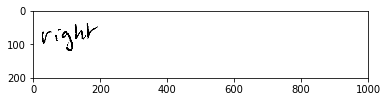

  'right' -> 'right<STOP>'
  Batch: 40 Loss: 0.8762932457491045
100


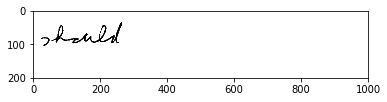

  'should' -> 'stembl<STOP>'


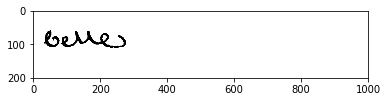

  'better' -> 'butter<STOP>'


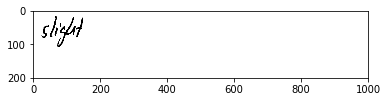

  'slight' -> 'stills<STOP>'
  Batch: 60 Loss: 0.9554433919371119
Test loss: 0.931089
Training epoch 17...
  Batch: 30 Loss: 0.5259970445739766
  Batch: 60 Loss: 0.5358124198734997
  Batch: 90 Loss: 0.4371350068634464
  Batch: 120 Loss: 0.5449483223982824
  Batch: 150 Loss: 0.39539997616457556
  Batch: 180 Loss: 0.4013067291744014
  Batch: 210 Loss: 0.45407578417765243
  Batch: 240 Loss: 0.5323128331677309
  Batch: 270 Loss: 0.4165095696148891
  Batch: 300 Loss: 0.3936763297171189


KeyboardInterrupt: ignored

In [51]:
for i in range(0, 100):
  max_size = 8
  prob = 0.3
  randx=20
  train(i, max_size, False, prob, randx)
  test(max_size, prob, randx)


#0 torch.Size([64, 122])


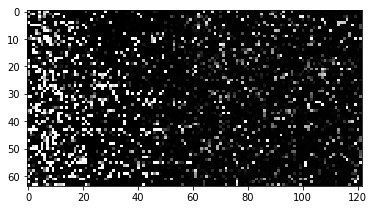

#1 torch.Size([64, 122])


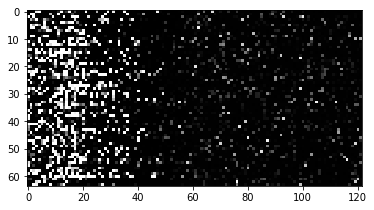

#2 torch.Size([64, 122])


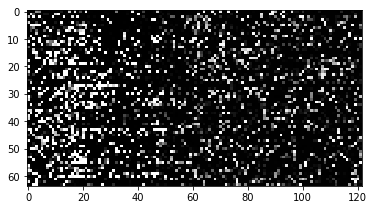

#3 torch.Size([64, 122])


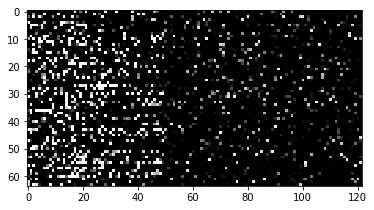

#4 torch.Size([64, 122])


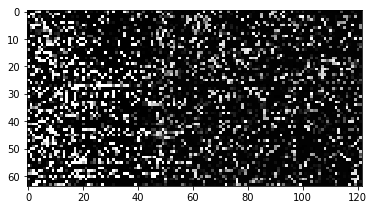

#5 torch.Size([64, 122])


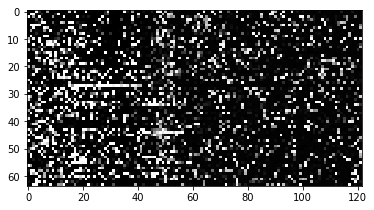

In [52]:
recognition_result = torch.LongTensor(batch_size, 30+1).to(device)
recognition_result.fill_(START)
old_symbol = torch.LongTensor(batch_size, 1).to(device)
test_set.to_start(8, equalize_freq=True)
batch = test_set.make_batch()
orig_data, target = batch
data = orig_data/255.0
data = data.unsqueeze(1).to(device)
target = target.to(device)
#data, target = artificial_data.make_random_batch(8, 20)
#data = data.unsqueeze(1).to(device)
#target = target.to(device)  


hidden = decoder.makeHidden().to(device)  
enc = encoder(data)
s = enc
s = s.detach()

old_symbol[:, 0] = START
for i in range(0, target.shape[1] + 1):
  decoder_result = decoder(s, old_symbol, hidden)
  dec = decoder_result.x
  hidden = decoder_result.hidden

  recognition_result[:, i] = dec.topk(1, dim=1)[1].flatten().detach()
  old_symbol[:, 0] = recognition_result[:, i]
  w = decoder.attention_weights.cpu().detach()[0]
  #w = w[0,:]
  print("#" + str(i) + " " + str(w.shape))
#  plt.imshow(w.numpy())
  plt.imshow(w, cmap="gray")
  plt.show()
